# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of november at noon**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt 
from scipy import linalg

In [ ]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [ ]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [ ]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += 1./lips_const[j]*np.dot(A[:,j],residuals)
        # update residuals:
        residuals  += np.dot(A[:,j],old_w_j) - np.dot(A[:,j],w[j])
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2 
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j]
        w[j] -= 1/lips_const[j]*gradient[j]
        # update gradient:
        gradient += gram[:,j] * (w[j] - old_w_j)
        # END TODO
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

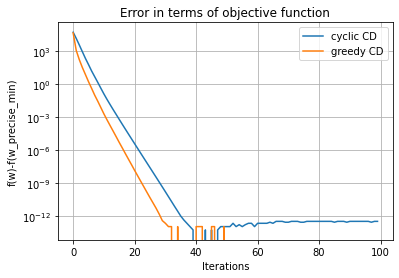

In [ ]:
# 1- Computing a precise minimum with linalg.solve 
w_precise_min = linalg.solve(np.dot(A.T,A),np.dot(A.T,b))
obj_star = 0.5 * np.linalg.norm(np.dot(A, w_precise_min) - b) ** 2
# 2- Computing both minimums using cyclic CD and greedy CD
n_iter = 10000
w_cyclic_CD, res_cyclic_CD = cyclic_cd(A, b, n_iter)
w_greedy_CD, res_greedy_CD = greedy_cd(A, b, n_iter)

plt.figure()
plt.semilogy((res_cyclic_CD - obj_star),label='cyclic CD')
plt.semilogy((res_greedy_CD - obj_star),label='greedy CD')
plt.xlabel('Iterations')
plt.ylabel('f(w)-f(w_precise_min)')
plt.title('Error in terms of objective function')
plt.legend()
plt.grid()
plt.show()

> **Comments:** <br>
- As we can see both algorithms have linear convergence. We notice that the greedy CD has a faster convergence than the cyclic CD but it costs more computational time since it require more computations at each step. 



>**Answer to the third point** <br>
- Greedy coordinate descent: Is an optimization algorithm that needs to compute at each iteration the full gradient, 
and selects the coordinate that makes the most progress according to the Gauss-Southwell rule.
- could you use greedy CD for L2 regularized logistic regression?<br>
In general, L2 regularization tend to decrease the magnitude of the feature variables without putting anyone of them to 0.
This doesn't help with greedy coordinate descent algorithm especially if we have a considerable number of features.
In fact, the algorithm will have to calculate the gradients from all the featuresand to iterate, each time, over all of them to choose the best one which is time consuming.
[However, if we use L1 regularization instead, we will have a sparse vector and thus faster computations.]
- could you use greedy CD to solve OLS, but with 100,000 features?<br>
The benefit of using OLS is that the gradient is easy to compute. However, GCD requires, not only, computing the full gradient (with 100,000 component) at each iteration,
but also, comparing them, which will be so time consuming.


## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*
> **Answer:**<br>
- We have : <br>
$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1 \Leftrightarrow 0 \in \partial  (\sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i \hat w^\top x_i} )  + \lambda \Vert \hat w \Vert_1) $ <br> $\Leftrightarrow \nabla \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i \hat w^\top x_i} )+ \partial \lambda \Vert \hat w \Vert_1\Leftrightarrow - \nabla \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i \hat w^\top x_i} ) \in \partial \lambda \Vert \hat w \Vert_1\ $ <br>
We have : <br>
* $ \frac{\partial \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i \hat w^\top x_i} )}{\partial \hat w_j}  = \sum_{i=1}^{n} \frac {-y_i X_{i,j}  e^{- y_i \hat w^\top x_i}}{e^{- y_i \hat w^\top x_i}} $
* $ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$<br>
So, we get for $\hat w = {0}_p$ : $∀j  $ $\partial \vert \cdot \vert (\hat w_j) \in [-1, 1]$. In this case, $ ∀j$ $ \sum_{i=1}^{n} \frac {y_i X_{i,j}  e^{- y_i \hat w^\top x_i}}{e^{- y_i \hat w^\top x_i}} \in [-\lambda,\lambda]$ <br> $ \Leftrightarrow$$∀j $$ \sum_{i=1}^{n} \frac {y_i X_{i,j}}{2} \in [-\lambda,\lambda] \Leftrightarrow ∀j |\frac {y_i X_{i,j}}{2}| \le \lambda  \Leftrightarrow  \max\limits_{j}|\sum_{i=1}^{n} \frac{{y_i  X_{i,j}}}{1+1}| \le \lambda \Leftrightarrow \frac{1}{2}||X^{T}y||_{\infty} \le \lambda$ <br>
Therefore, we conclude that : <br>
$$\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$$ with: $$\lambda_{max}  = \frac{1}{2}||X^{T}y||_{\infty}$$ 


<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

*answer here*
> **Answer:**<br>
Let $g_{j} (w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i  w^\top x_i})$. We will compute $\nabla ^2 g_j(wj)$: <br>
We have : $\nabla g_j(wj) = \frac { \partial g_{j}(w)}{\partial w_j} = \sum_{i=1}^{n} \frac {-y_i X_{i,j}  e^{- y_i w^\top x_i}}{e^{- y_i w^\top x_i}}= \sum_{i=1}^{n} \frac {-y_i X_{i,j}}{e^{y_i w^\top x_i}}$.<br>
Therefore, $\nabla ^2 g_j(wj) = \sum_{i=1}^{n} \frac {y_i ^2 X_{ij}^2 e^{y_i w^\top x_i}} {(1+e^{y_i w^\top x_i})^2}. $ <br>
Using the fact that : <br>
* $y_i \in$ {-1,1} $\Leftrightarrow y_i ^2= 1$
* $\frac {e^{y_i w^\top x_i}}{(1+e^{y_i w^\top x_i})^2}\le \frac{1}{4}$<br>
we obtain : <br>
$$|\nabla ^2 g_j(wj)|\le \frac{1}{4} \sum_{i=1}^{n} X_{ij}^2 = \frac{||X_j||^{2}}{4}$$<br>
$\Longrightarrow$ The coordinate-wise Lipschitz constant of the smooth term $\gamma_j$ can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$


<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [ ]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros(n_iter)
    
    # TODO
    lips_const = (1/4) * np.linalg.norm(X, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = np.dot(X[:,j], y * (sigmoid(y * Xw) - 1))
            w[j] = soft_thresh(old_w_j - (1/lips_const[j]) * grad_j, lamb/lips_const[j])
            
            if old_w_j != w[j]:
              Xw += X[:,j] * w[j] - X[:,j] * old_w_j
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [ ]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [ ]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [ ]:
def prox_GD_lasso(A,b,lamb,n_iter):
    n_samples, n_features = A.shape
    w = np.zeros(n_features)
    all_objs = np.empty(n_iter)
    lips_const = np.linalg.norm(X, ord=2) ** 2
    
    for t in range(n_iter):
        grad_linreg = np.dot(np.dot(A.T,A),w)-np.dot(A.T,b)
        w = soft_thresh(w - 1./lips_const*grad_linreg,lamb/lips_const)
        
        all_objs[t] = 0.5 * np.linalg.norm(A.dot(w) - b) ** 2 + lamb * norm(w, ord=1)
    
    return w, all_objs

In [ ]:
def prox_CD_lasso(A, b, lamb, n_iter):
    n_samples, n_features = A.shape
    w = np.zeros(n_features)
    residuals = b - A.dot(w) 
    all_objs = np.zeros(n_iter)
    lips_const = np.linalg.norm(A, axis=0) ** 2
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            w[j] = soft_thresh(old_w_j - 1. / lips_const[j] * A[:,j].dot(residuals) ,
                               lamb / lips_const[j])
            
            if old_w_j != w[j]:
                residuals += ( - A[:,j].dot(old_w_j) + A[:,j].dot(w[j]) )
           
        all_objs[t] = (residuals ** 2).sum() / 2. + lamb * norm(w, ord=1)
    
    return w, all_objs

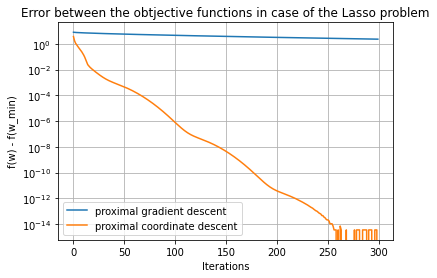

In [ ]:
n_iter = 300
w_prox_GD, objective_prox_GD = prox_GD_lasso(X,y,lambd,n_iter)
w_prox_CD, objective_prox_CD = prox_CD_lasso(X,y,lambd,n_iter) 

plt.semilogy(objective_prox_GD - objective_prox_CD[-1],label='proximal gradient descent')
plt.semilogy(objective_prox_CD - objective_prox_CD[-1],label='proximal coordinate descent')
plt.title('Error between the obtjective functions in case of the Lasso problem')
plt.ylabel('f(w) - f(w_min)')
plt.xlabel('Iterations')
plt.legend()
plt.grid()
plt.show()

> **Comments:**<br>
- The figure above represents the difference between the objective function at w and at w_min which is the minimum obtained by the proximal CD (we considered this minimum as the true ). We notice from the plot, that proxiaml CD have better convergence performance than proximal GD which mean for the Lasso probelm it is better to use proximal CD than proximal GD since it is faster and costs less computational time.
